In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import sklearn.metrics as metrics
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import VGG16

In [ ]:
!pip install -q kaggle

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "heathcliffexe"
os.environ['KAGGLE_KEY'] = "c0337b1bdab1a5f08a840f784aa89fb3"

In [ ]:
!kaggle datasets download -d phucthaiv02/butterfly-image-classification

 96% 217M/226M [00:03<00:00, 70.8MB/s]
100% 226M/226M [00:03<00:00, 59.7MB/s]


In [ ]:
!unzip "/content/butterfly-image-classification.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train/Image_2348.jpg  
  inflating: /content/dataset/train/Image_2349.jpg  
  inflating: /content/dataset/train/Image_235.jpg  
  inflating: /content/dataset/train/Image_2350.jpg  
  inflating: /content/dataset/train/Image_2351.jpg  
  inflating: /content/dataset/train/Image_2352.jpg  
  inflating: /content/dataset/train/Image_2353.jpg  
  inflating: /content/dataset/train/Image_2354.jpg  
  inflating: /content/dataset/train/Image_2355.jpg  
  inflating: /content/dataset/train/Image_2356.jpg  
  inflating: /content/dataset/train/Image_2357.jpg  
  inflating: /content/dataset/train/Image_2358.jpg  
  inflating: /content/dataset/train/Image_2359.jpg  
  inflating: /content/dataset/train/Image_236.jpg  
  inflating: /content/dataset/train/Image_2360.jpg  
  inflating: /content/dataset/train/Image_2361.jpg  
  inflating: /content/dataset/train/Image_2362.jpg  
  inflating: /content/dataset/train/Image_2363.jpg

### EDA

In [ ]:
import pandas as pd
train_df = pd.read_csv('dataset/Training_set.csv')
test_df = pd.read_csv('dataset/Testing_set.csv')

In [ ]:
train_df.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [ ]:
test_df.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [ ]:
classes = train_df['label'].value_counts()
print(classes)

MOURNING CLOAK    131
SLEEPY ORANGE     107
ATALA             100
BROWN SIPROETA     99
CRECENT            97
                 ... 
AMERICAN SNOOT     74
GOLD BANDED        73
MALACHITE          73
CRIMSON PATCH      72
WOOD SATYR         71
Name: label, Length: 75, dtype: int64


In [ ]:
num_classes= 75
IMAGE_SHAPE = [224, 224]
batch_size= 32

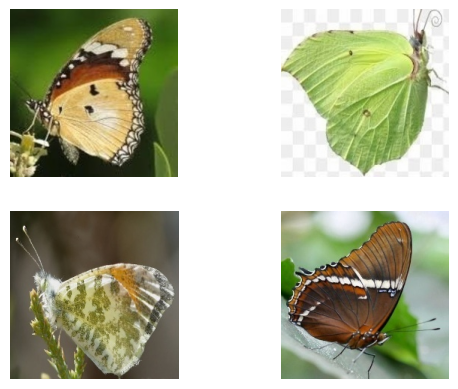

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

dir_path = 'dataset/train/'

image_files = os.listdir(dir_path)

fig, axes = plt.subplots(nrows=2, ncols=2)

for ax, image_file in zip(axes.flatten(), image_files):
    img_path = os.path.join(dir_path, image_file)
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')

plt.show()

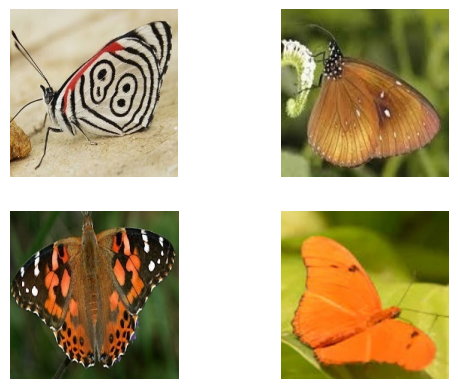

In [ ]:
dir_path = 'dataset/test/'

image_files = os.listdir(dir_path)

fig, axes = plt.subplots(nrows=2, ncols=2)

for ax, image_file in zip(axes.flatten(), image_files):
    img_path = os.path.join(dir_path, image_file)
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')

plt.show()

Pada EDA dilakukan load data, pengecekan dan pengecekan data, dari yang telah dilakukan didapatkan bahwa pada data training terdapat file yang menyimpan informasi nama dan labelnya, sedangkan pada testing hanya ada nama file saja dan tidak ada target, hal ini penting karena jika tidak ada target tidak bisa digunakan untuk evaluasi metrik. selanjutnya diketahui bahwa data train memiliki 75 kelas.

### Preprocess

In [ ]:
from sklearn.model_selection import train_test_split

train, temp = train_test_split(train_df, test_size=0.2, random_state=42)

val, test = train_test_split(temp, test_size=0.5, random_state=42)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory="dataset/train",
    x_col="filename",
    y_col="label",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224))

val_generator=datagen.flow_from_dataframe(
    dataframe=val,
    directory="dataset/train",
    x_col="filename",
    y_col="label",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=(224,224))

eval_generator=datagen.flow_from_dataframe(
    dataframe=test,
    directory="dataset/train",
    x_col="filename",
    y_col="label",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=(224,224))

test_generator=datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="dataset/test",
    x_col="filename",
    y_col=None,
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(224,224))

Found 5199 validated image filenames belonging to 75 classes.
Found 650 validated image filenames belonging to 75 classes.
Found 650 validated image filenames belonging to 75 classes.
Found 2786 validated image filenames.


Selanjutnya dilakukan preproses pada data sebelum digunakan yaitu discaling dan displit dari training untuk menjadi data train, validation serta eval untuk evaluasi metrik dengan rasio 80:10:10. hal ini dikarenakan pada data test tidak ada labelnya jadi data train displit menjadi 3, validation untuk validasi training dan eval untuk evaluasi metrik, validation dan test berbeda karena jika sama maka akan terjadi kebocoran data, selanjutnya data test asli akan digunakan untuk prediksi nantinya dan disimpan label yang berhasil diklasifikasikan pada file test.csv

### Build

#### Modeling

In [ ]:
vgg = VGG16(input_shape = (224,224,3), weights = 'imagenet', include_top = False)

for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
x = Dense(128, activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
x = Dense(num_classes, activation = 'softmax')(x)

model = Model(inputs = vgg.input, outputs = x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


Dilakukan pemodelan dengan pendekatan transfer learning dimana digunakan model VGG16 yang telah dilatih sebelumnya untuk melakukan transfer learning. Layer-layer dalam VGG16 diatur agar tidak dapat dilatih ulang. Kemudian, beberapa layer Dense ditambahkan dan akan digunakan untuk melatih dengan data

#### Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

epochs = 10
#checkpoint = ModelCheckpoint(filepath='finalvgg16model.h5', verbose=1, save_best_only=True)
training_steps_per_epoch = np.ceil(train_generator.samples / batch_size)
validation_steps_per_epoch = np.ceil(val_generator.samples / batch_size)

model.fit(train_generator, steps_per_epoch=training_steps_per_epoch, validation_data=val_generator, validation_steps=validation_steps_per_epoch,
                        epochs=epochs, verbose=1)
print('Training Completed!')

Epoch 1/10
163/163 [==============================] - 39s 173ms/step - loss: 3.5264 - accuracy: 0.1768 - val_loss: 2.3247 - val_accuracy: 0.4246
Epoch 2/10
163/163 [==============================] - 22s 137ms/step - loss: 1.5118 - accuracy: 0.5918 - val_loss: 1.5903 - val_accuracy: 0.5785
Epoch 3/10
163/163 [==============================] - 22s 137ms/step - loss: 0.6953 - accuracy: 0.8213 - val_loss: 1.1958 - val_accuracy: 0.6585
Epoch 4/10
163/163 [==============================] - 22s 137ms/step - loss: 0.3614 - accuracy: 0.9175 - val_loss: 1.2040 - val_accuracy: 0.6754
Epoch 5/10
163/163 [==============================] - 26s 159ms/step - loss: 0.1873 - accuracy: 0.9663 - val_loss: 1.2279 - val_accuracy: 0.6831
Epoch 6/10
163/163 [==============================] - 24s 148ms/step - loss: 0.0846 - accuracy: 0.9929 - val_loss: 1.0730 - val_accuracy: 0.7031
Epoch 7/10
163/163 [==============================] - 23s 139ms/step - loss: 0.0453 - accuracy: 0.9990 - val_loss: 1.1042 - val_ac

#### Evaluation

Dari hasil training yang telah dilakukan, awalnya saya mengalami underfit pada hasilnya hanya mendapat akurasi 0.12 saja, lalu saya mencoba menambahkan rescaling dan shuffle pada data dan akhirnya bisa mendapatkan akurasi 0.9 lalu val akurasi 0.72, namun saya mengira model ini overfit dan saya coba untuk tambahkan dropout dan regularization namun hasilnya kembali buruk yaitu 0.15.

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report

y_pred = model.predict(eval_generator, eval_generator.samples / batch_size)
val_preds = np.argmax(y_pred, axis=1)
val_trues = eval_generator.classes

print(classification_report(val_trues, val_preds))

21/21 [==============================] - 3s 122ms/step
              precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.83      0.91      0.87        11
           2       0.78      0.78      0.78         9
           3       0.88      0.88      0.88         8
           4       0.85      0.92      0.88        12
           5       1.00      1.00      1.00         6
           6       0.71      0.71      0.71         7
           7       0.33      0.33      0.33         6
           8       0.88      0.78      0.82         9
           9       0.88      0.70      0.78        10
          10       0.67      0.80      0.73         5
          11       1.00      0.86      0.92         7
          12       0.77      0.83      0.80        12
          13       0.85      1.00      0.92        11
          14       0.64      0.70      0.67        10
          15       0.82      1.00      0.90         9
          16       1.00   

Selanjutnya saya coba cek pada data test dimana mendapatkan akurasi 0.75, yang mana lumayan baik, walaupun masih overfit jika dilihat dari gap hasil train dan test.

In [ ]:
import sklearn.metrics as metrics
y_pred = model.predict(eval_generator, eval_generator.samples / batch_size)
val_preds = np.argmax(y_pred, axis=1)
val_trues = eval_generator.classes
cm = metrics.confusion_matrix(val_trues, val_preds)
cm

21/21 [==============================] - 2s 118ms/step


array([[ 9,  0,  0, ...,  0,  0,  0],
       [ 0, 10,  0, ...,  0,  0,  0],
       [ 0,  0,  7, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  4,  0,  0],
       [ 0,  1,  0, ...,  0,  5,  0],
       [ 0,  0,  0, ...,  0,  0,  7]])

#### Predict

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
img_path = 'dataset/test/Image_1.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds=model.predict(x)

butterfly_classes = list(train_df['label'].unique())

pred = np.argmax(preds, axis=-1)

print(butterfly_classes[pred[0]])

1/1 [==============================] - 0s 63ms/step
RED POSTMAN


In [ ]:
test_df['label'] = ''

for i in range(len(test_df)):
    img_path = 'dataset/test/' + test_df.loc[i, 'filename']
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    pred = np.argmax(preds, axis=-1)

    test_df.loc[i, 'label'] = butterfly_classes[pred[0]]

test_df.to_csv('test-base-model.csv', index=False)

1/1 [==============================] - 0s 18ms/step


In [ ]:
test_df.head()

,filename,label
0,Image_1.jpg,RED POSTMAN
1,Image_2.jpg,RED POSTMAN
2,Image_3.jpg,ORANGE OAKLEAF
3,Image_4.jpg,BANDED ORANGE HELICONIAN
4,Image_5.jpg,ORANGE OAKLEAF


In [ ]:
test_df = test_df.drop('label', axis=1)

In [ ]:
test_df.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


Dihapus kolom label pada test_df karena akan dilakukan lagi klasifikasi dan penyimpanan label dengan tuned model.

In [ ]:
model.save('base-model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('base-model.keras')

# reloaded_model = tf.keras.models.load_model('tuned_model.keras')

### Hyperparameter Tuning

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.1 MB/s eta 0:00:00


In [ ]:
from kerastuner.tuners import RandomSearch

def build_model(hp):
    vgg = VGG16(input_shape = (224,224,3), weights = 'imagenet', include_top = False)
    for layer in vgg.layers:
        layer.trainable = False

    x = Flatten()(vgg.output)
    x = Dense(units=hp.Int('dense_1_units', min_value=128, max_value=256, step=32), activation='relu')(x)
    x = Dense(units=hp.Int('dense_2_units', min_value=64, max_value=128, step=32), activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=vgg.input, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='output',
    project_name='VGG16')

tuner.search(train_generator, epochs=10 , validation_data=val_generator)


Trial 5 Complete [00h 04m 55s]
val_accuracy: 0.7815384864807129

Best val_accuracy So Far: 0.7815384864807129
Total elapsed time: 00h 24m 49s


Didapatkan model dengan parameter baru yang memiliki val akurasi lebih bagus dari sebelumnya yaitu 0.72 dan sekarang didapat 0.78

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Dense 1 units: {best_hp.get('dense_1_units')}")
print(f"Dense 2 units: {best_hp.get('dense_2_units')}")
print(f"Learning rate: {best_hp.get('learning_rate')}")

Dense 1 units: 160
Dense 2 units: 128
Learning rate: 0.001


In [ ]:
model_tuned = tuner.get_best_models(num_models=1)[0]

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report

y_pred = model_tuned.predict(eval_generator, eval_generator.samples / batch_size)
val_preds = np.argmax(y_pred, axis=1)
val_trues = eval_generator.classes

print(classification_report(val_trues, val_preds))

21/21 [==============================] - 3s 118ms/step
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        13
           1       0.69      1.00      0.81        11
           2       1.00      0.67      0.80         9
           3       1.00      1.00      1.00         8
           4       0.91      0.83      0.87        12
           5       0.62      0.83      0.71         6
           6       0.67      0.86      0.75         7
           7       0.60      0.50      0.55         6
           8       0.64      0.78      0.70         9
           9       1.00      0.80      0.89        10
          10       1.00      1.00      1.00         5
          11       0.88      1.00      0.93         7
          12       0.90      0.75      0.82        12
          13       0.85      1.00      0.92        11
          14       0.88      0.70      0.78        10
          15       0.64      1.00      0.78         9
          16       0.75   

Hasil dari hyperparemter tuning di model mendapatkan akurasi yang sedikit lebih bagus dimana sebelumnya didpaatkan 0.75 sekarang 0.78

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
img_path = 'dataset/test/Image_1.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds=model_tuned.predict(x)

butterfly_classes = list(train_df['label'].unique())

pred = np.argmax(preds, axis=-1)

print(butterfly_classes[pred[0]])

1/1 [==============================] - 0s 163ms/step
RED POSTMAN


Hasil masih sama dengan sebelumnya "RED POSTMAN"

In [ ]:
test_df['label'] = ''

for i in range(len(test_df)):
    img_path = 'dataset/test/' + test_df.loc[i, 'filename']
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model_tuned.predict(x)
    pred = np.argmax(preds, axis=-1)

    test_df.loc[i, 'label'] = butterfly_classes[pred[0]]

test_df.to_csv('test.csv', index=False)

1/1 [==============================] - 0s 19ms/step


In [ ]:
test_df.head()

,filename,label
0,Image_1.jpg,RED POSTMAN
1,Image_2.jpg,CABBAGE WHITE
2,Image_3.jpg,BLACK HAIRSTREAK
3,Image_4.jpg,CABBAGE WHITE
4,Image_5.jpg,ORANGE OAKLEAF


### Save Reload Model

In [ ]:
# test_df.to_csv('test-tuned-model.csv', index=False)

In [ ]:
model.save('tuned-model.keras')

reloaded_model = tf.keras.models.load_model('tuned-model.keras')

Kesimpulannya adalah dengan transfer learning ini model bisa mendapatkan hasil yang cukup bagus dengan waktu yang relatif lebih singkat karena menggunakan bobot yang sudah dilatih, pada pelatihan hanya dengan 5 epoch saja sudah cukup untuk dilihat hasilnya, namun pada pelatihan yang telah dilkukan sepertinya terjadi overfit dimana data latih dipelajari terlalu baik, hal ini bisa terjadi karena data train yang displit menjadi tiga bagian membuat nya kurang optimal untuk pelatihan, lalu dilakukan paramter tuning yaitu dengan dan tanpa rescaling, penambahan layer dropout dan regularization serta tuning parameter dengan keras tuner dimana mendapat sedikit peningkatan akurasi.